# EE 590 Final Project
Title of Project: Trading Strategy by Machine Learning

## Important Imports

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
import datetime as dt

In [2]:
####source code: https://www.roelpeters.be/many-ways-to-calculate-the-rsi-in-python-pandas/

def rsi(df, periods = 6, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['Adj Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [3]:
def stock(ticker):
    
    ticker_df = yf.download(ticker, 
                      start='2000-01-01', 
                      end='2021-08-31', 
                      progress=False)
    
    ticker = ticker_df.loc[:,['Adj Close','Open','Volume']]
    
    ticker_df['fivedays_avg_hi'] = ticker_df.loc[:,'High'].rolling(window=5).mean() 

    ticker['hi_over_fivedavghi'] = ticker_df['High']/ticker_df['fivedays_avg_hi']

    ticker_df['fivedays_avg_low'] = ticker_df.loc[:,'Low'].rolling(window=5).mean() 

    ticker['low_over_fivedavglow'] = ticker_df['Low']/ticker_df['fivedays_avg_low']

    ticker['Five Days Avg Close'] = ticker.loc[:,'Adj Close'].ewm(alpha = 0.1, adjust = False).mean()

    ticker['Five Days Avg Volume'] = ticker.loc[:,'Volume'].rolling(window=5).mean()

    ticker['momentum'] = ticker['Adj Close']/ticker['Adj Close'].shift(5)-1
    
    ticker['RSI6'] = rsi(ticker)
    
    ticker['RSI12'] = rsi(ticker, periods = 12)
    
    ticker['RSI24'] = rsi(ticker, periods = 24)
    
    ticker['std'] = ticker.loc[:,'Adj Close'].rolling(window=5).std()

    ticker['Adj Close 3 avg'] = ticker.loc[:, 'Adj Close'].rolling(window=3).mean()
    
    Check = [1 if ticker['Adj Close 3 avg'].iloc[i+6] > ticker['Adj Close'].iloc[i] 
                     else 0 for i in range(0,len(ticker['Adj Close'])-6)]

    ticker = ticker.drop(ticker.tail(6).index)

    ticker['check'] = Check
    
    return ticker

In [7]:
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

first_table = payload[0]
second_table = payload[1]

ft = first_table
symbols = ft['Symbol'].values.tolist()

##remove ticker that cause syntax error
symbols.remove('BRK.B')
symbols.remove('BF.B')

In [8]:
##screen out the stock that fit timeline
##the list will call final_ticker_list

stocklist = symbols
final_ticker_list = []

for i in stocklist:
    ticker_df = yf.download(i, 
                      start='2000-01-01', 
                      end='2021-08-31', 
                      progress=False)
    if ticker_df.index[0] <= dt.datetime(2005, 1, 1):
        final_ticker_list.append(i)

In [263]:
def backtest(ticker):    
    
    test = X_test.copy()
    
    test['prediction'] = prediction.tolist()
    
    test['day_of_week'] = test.index.day_name()
    
    signal = test['prediction'].resample('W-FRI').mean()
    
    test = pd.concat([test,signal.rename('signal')], axis=1)
    
    test = test.dropna(axis = 0, subset = ['Adj Close'])
    
    test['signal_shift'] = test.signal.shift(1)
    
    test['open'] = ticker['Open']

    test['status'] = test.prediction.shift(1).fillna(0)
    
    test['signal_shift'] = test['signal_shift'].fillna(method = 'ffill')
    
    test['signal_shift'] = test['signal_shift'].fillna(0)
    
#    test = test.dropna(axis = 0, subset = ['test_1shift'])

    test['buy_cost'] = test.open[np.where((test.signal_shift >=0.6) * (test.signal_shift.shift(1) < 0.6))[0]]

    test['sell_cost'] = test.open[np.where((test.signal_shift <0.6) * (test.signal_shift.shift(1) >= 0.6))[0]]
    
    test= test.fillna(0)
    
    buy_cost = np.array(test.buy_cost[test.buy_cost != 0])
    sell_price = np.array(test.sell_cost[test.sell_cost != 0])

    if len(buy_cost) > len(sell_price) :
        buy_cost = buy_cost[:-1]

    trade_return = sell_price / buy_cost - 1
    
    test['trade_ret'] = 0
    
    sell_dates = test.sell_cost[test.sell_cost != 0].index
    
    test.loc[sell_dates, 'trade_ret'] = trade_return
    
    test.loc[test['signal_shift'] < 0.6, 'signal_shift'] = 0
    
    test.loc[test['signal_shift'] >= 0.6, 'signal_shift'] = 1
    
    test['open_ret'] = test.open / test.open.shift(1) - 1
    
    test['strategy_ret'] = test.signal_shift * test.open_ret
    
    test['strategy_equity'] = (test.strategy_ret + 1).cumprod()
    
    test['buy_and_hold_equity'] = (test.open_ret + 1).cumprod()
    
####results####
    
    trade_count = len(sell_dates)
    
    win_rate = (trade_return > 0).sum()/trade_count
    
    profit_factor = trade_return[trade_return > 0].sum() / abs(trade_return[trade_return < 0].sum())
    
    acc_return = test.strategy_equity[-1] - 1
    
    IRR_strategy = test.strategy_equity[-1] ** (252/len(test)) - 1
    
    IRR_buyhold = test.buy_and_hold_equity[-1] ** (252/len(test)) - 1
    
    return IRR_strategy, IRR_buyhold, win_rate, profit_factor, trade_count, test['strategy_ret'], test['open_ret']
    
#    test2.buy_and_hold_equity.plot()
#    test2.strategy_equity.plot()
#    test.strategy_net_equity[-1]

In [310]:
%%time
stock_list = final_ticker_list
ticker_list = []
score_list = []
IRR_strategy_list = []
IRR_buyhold_list = []
win_rate_list = []
profit_factor_list = []
trade_count_list = []
column_list = []
openret_list = []

for i in stock_list:
    
    df = stock(i)
    
    ticker_list.append(df)
    
    xgbc = XGBClassifier(silent=False, 
                     scale_pos_weight=1,
                     learning_rate=0.01,  
                     colsample_bytree = 1,
                     subsample = 0.8,
                     objective='binary:logistic', 
                     n_estimators=1500, 
                     reg_alpha = 0.3,
                     max_depth=5, 
                     gamma=1,
                     use_label_encoder=False, 
                     eval_metric='auc'
                     )
    
    X = df[['Adj Close','Volume','hi_over_fivedavghi','low_over_fivedavglow',
                'Five Days Avg Close','Five Days Avg Volume','momentum','RSI6','RSI12','RSI24','std']]
    Y = df['check']
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42, shuffle = False)
    
#    xgbc = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
 
    xgbc = XGBClassifier(silent=False, 
                     scale_pos_weight=1,
                     learning_rate=0.01,  
                     colsample_bytree = 1,
                     subsample = 0.8,
                     objective='binary:logistic', 
                     n_estimators=1500, 
                     reg_alpha = 0.3,
                     max_depth=5, 
                     gamma=1,
                     use_label_encoder=False, 
                     eval_metric='auc'
                     )
    
    xgbc.fit(X_train, Y_train)
    
    score = xgbc.score(X_test, Y_test)
    
    score_list.append(score) 
    
    prediction = xgbc.predict(X_test)
    
    IRR_strategy, IRR_buyhold, win_rate, profit_factor, trade_count, column, openret = backtest(df)
    
    
    
    IRR_strategy_list.append(IRR_strategy)
    
    IRR_buyhold_list.append(IRR_buyhold)
    
    win_rate_list.append(win_rate)
    
    profit_factor_list.append(profit_factor)
    
    trade_count_list.append(trade_count)
    
    column_list.append(column)
    openret_list.append(openret)

[19:01:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<ipython-input-263-a0842fbcada1>:65: RuntimeWarning: divide by zero encountered in double_scalars
  profit_factor = trade_return[trade_return > 0].sum() / abs(trade_return[trade_return < 0].sum())


[19:01:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

<ipython-input-263-a0842fbcada1>:63: RuntimeWarning: invalid value encountered in long_scalars
  win_rate = (trade_return > 0).sum()/trade_count
<ipython-input-263-a0842fbcada1>:65: RuntimeWarning: invalid value encountered in double_scalars
  profit_factor = trade_return[trade_return > 0].sum() / abs(trade_return[trade_return < 0].sum())


[19:01:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:01:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[19:03:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:03:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:04:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[19:06:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:06:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:06:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[19:08:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:08:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[19:10:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:10:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:10:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:02:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:02:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:02:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:04:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:04:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:04:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:06:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:06:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:07:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:08:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:09:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:09:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:11:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:11:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:11:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:13:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:16:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:16:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:18:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:18:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:18:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:21:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:21:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:21:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:23:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:23:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:23:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:25:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:28:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:28:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:28:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:30:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:30:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:30:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:32:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:32:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:33:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[21:35:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:35:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:35:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

In [312]:
results_408 = pd.DataFrame(list(zip(stock_list, score_list, IRR_strategy_list,
                                 IRR_buyhold_list, win_rate_list, profit_factor_list, trade_count_list)), 
                       columns =['Stock Name', 'Accuracy', 'IRR_strategy','IRR_buyhold','Win rate','Profit factor', 'Trade count'])

results_408.sort_values(by='Accuracy', ascending=False).head(100)

,Stock Name,Accuracy,IRR_strategy,IRR_buyhold,Win rate,Profit factor,Trade count
5,ADBE,0.645546,0.437366,0.437116,NaN,NaN,0
249,MTD,0.626263,0.287606,0.292426,1.000000,inf,1
260,MCO,0.624426,0.314758,0.307155,1.000000,inf,2
167,IT,0.609734,0.228297,0.256385,0.750000,5.019741,4
193,IDXX,0.605142,0.405133,0.393102,1.000000,inf,5
244,MCD,0.603306,0.126211,0.128759,0.500000,2.433478,2
337,SHW,0.602388,0.199869,0.264046,0.777778,8.171369,9
81,CRL,0.592488,0.471916,0.433422,0.857143,14.938252,14
16,ALGN,0.588406,0.452984,0.438325,0.750000,10.423224,4
363,TT,0.586777,0.265530,0.277516,0.850000,50.540643,20


In [47]:
final_results = results[(results['Trade count'] > 10) & (results['IRR_strategy'] > 0.15) & 
                        (results['diff'] > 0) & (results['Score'] > 0.5)]

In [359]:
results_random = results_408[results_408['Trade count'] > 10]

,Stock Name,Score,IRR_strategy,IRR_buyhold,Win rate,Profit factor,Trade count
0,OKE,0.505969,0.256330,-0.024501,0.785714,4.146281,14
1,MCHP,0.556474,0.187047,0.157543,0.736842,6.129762,19
2,CCL,0.573003,0.266860,-0.211886,0.666667,3.083970,18
3,PENN,0.507805,0.559075,0.332140,0.650000,7.248368,20
4,IPG,0.552801,0.230890,0.100416,0.733333,2.801877,30
5,ADSK,0.546373,0.405143,0.351235,0.705882,5.230068,34
6,ANTM,0.545090,0.215510,0.178673,0.652174,4.027975,23
7,CRL,0.592488,0.471916,0.433422,0.857143,14.938252,14
8,FCX,0.547291,0.497640,0.237506,0.687500,3.921151,32
9,HSIC,0.562902,0.171004,0.028911,0.666667,2.386126,30


In [52]:
stock_list_final25 = final_results['Stock Name'].to_list()

In [86]:
%%time
stock_list = stock_list_final25
ticker_list = []
score_list = []
IRR_strategy_list = []
IRR_buyhold_list = []
win_rate_list = []
profit_factor_list = []
trade_count_list = []
column_list = []

for i in stock_list:
    
    df = stock(i)
    
    ticker_list.append(df)
    
    xgbc = XGBClassifier(silent=False, 
                     scale_pos_weight=1,
                     learning_rate=0.01,  
                     colsample_bytree = 1,
                     subsample = 0.8,
                     objective='binary:logistic', 
                     n_estimators=1500, 
                     reg_alpha = 0.3,
                     max_depth=5, 
                     gamma=1,
                     use_label_encoder=False, 
                     eval_metric='auc'
                     )
    
    X = df[['Adj Close','Volume','hi_over_fivedavghi','low_over_fivedavglow',
                'Five Days Avg Close','Five Days Avg Volume','momentum','RSI6','RSI12','RSI24','std']]
    Y = df['check']
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42, shuffle = False)
    
#    xgbc = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
 
    xgbc = XGBClassifier(silent=False, 
                     scale_pos_weight=1,
                     learning_rate=0.01,  
                     colsample_bytree = 1,
                     subsample = 0.8,
                     objective='binary:logistic', 
                     n_estimators=1500, 
                     reg_alpha = 0.3,
                     max_depth=5, 
                     gamma=1,
                     use_label_encoder=False, 
                     eval_metric='auc'
                     )
    
    xgbc.fit(X_train, Y_train)
    
    score = xgbc.score(X_test, Y_test)
    
    score_list.append(score) 
    
    prediction = xgbc.predict(X_test)
    
    IRR_strategy, IRR_buyhold, win_rate, profit_factor, trade_count, column = backtest(df)
    
    
    
    IRR_strategy_list.append(IRR_strategy)
    
    IRR_buyhold_list.append(IRR_buyhold)
    
    win_rate_list.append(win_rate)
    
    profit_factor_list.append(profit_factor)
    
    trade_count_list.append(trade_count)
    
    column_list.append(column)

[16:59:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[16:59:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:59:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:59:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

[17:01:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:01:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:01:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

In [55]:
results2 = pd.DataFrame(list(zip(stock_list, score_list, IRR_strategy_list,
                                 IRR_buyhold_list, win_rate_list, profit_factor_list, trade_count_list)), 
                       columns =['Stock Name', 'Score', 'IRR_strategy','IRR_buyhold','Win rate','Profit factor', 'Trade count'])

results2.sort_values(by='IRR_strategy', ascending=False).head(30)

results2['diff'] = results2['IRR_strategy'] - results2['IRR_buyhold']

In [56]:
results2

,Stock Name,Score,IRR_strategy,IRR_buyhold,Win rate,Profit factor,Trade count,diff
0,MMM,0.492195,0.064570,-0.001612,0.564103,1.706477,39,0.066182
1,ABT,0.421488,0.017282,0.275914,1.000000,inf,2,-0.258632
2,ABMD,0.438935,0.068303,0.243293,0.500000,1.434263,14,-0.174990
3,ACN,0.366963,-0.037008,0.262013,0.588235,1.288010,17,-0.299021
4,ATVI,0.530762,0.125937,0.117068,0.666667,4.143774,21,0.008869
...,...,...,...,...,...,...,...,...
403,XLNX,0.446281,0.002135,0.218422,1.000000,inf,2,-0.216287
404,YUM,0.435262,0.016281,0.176519,0.700000,1.482387,10,-0.160239
405,ZBRA,0.418733,-0.020719,0.508194,0.200000,0.163280,5,-0.528913
406,ZBH,0.516320,0.140662,0.061857,0.500000,2.245662,22,0.078805


In [57]:
final_results2 = results2[(results2['Trade count'] > 10) & (results2['IRR_strategy'] > 0.15) & 
                        (results2['diff'] > 0) & (results2['Score'] > 0.5)]

In [60]:
final_results2

,Stock Name,Score,IRR_strategy,IRR_buyhold,Win rate,Profit factor,Trade count,diff
34,ANTM,0.553106,0.219348,0.178673,0.666667,4.027796,24,0.040675
45,ADSK,0.552801,0.395996,0.351235,0.727273,5.393691,33,0.044761
59,BIIB,0.529844,0.305943,0.041243,0.571429,2.384820,28,0.264700
75,CCL,0.572084,0.244992,-0.211886,0.647059,2.970975,17,0.456878
81,CRL,0.592488,0.471916,0.433422,0.857143,14.938252,14,0.038494
100,CAG,0.568411,0.169503,-0.035299,0.750000,3.649630,20,0.204802
134,ECL,0.584022,0.176522,0.133399,0.840000,7.576960,25,0.043124
141,EFX,0.528926,0.353764,0.153734,0.705882,4.003110,34,0.200030
153,FFIV,0.507805,0.172596,0.086033,0.588235,5.640929,17,0.086563
162,F,0.527089,0.183091,0.022169,0.593750,3.561348,32,0.160922


In [80]:
stock_list_final25_1 = final_results['Stock Name'].to_list()

In [81]:
stock_list_final25_2 = final_results2['Stock Name'].to_list()

In [83]:
stock_list_final25 = list(set(stock_list_final25_1 + stock_list_final25_2))


In [ ]:
##############################

In [87]:
results3 = pd.DataFrame(list(zip(stock_list, score_list, IRR_strategy_list,
                                 IRR_buyhold_list, win_rate_list, profit_factor_list, trade_count_list)), 
                       columns =['Stock Name', 'Score', 'IRR_strategy','IRR_buyhold','Win rate','Profit factor', 'Trade count'])

results3.sort_values(by='IRR_strategy', ascending=False).head(30)

results3['diff'] = results3['IRR_strategy'] - results3['IRR_buyhold']

In [98]:
final_results3 = results3[(results3['Trade count'] > 10) & (results3['IRR_strategy'] > 0.15) & 
                        (results3['diff'] > 0) & (results3['Score'] > 0.5) & (results3['diff']>0.024)]

In [356]:
results3

,Stock Name,Score,IRR_strategy,IRR_buyhold,Win rate,Profit factor,Trade count,diff
0,OKE,0.504132,0.251444,-0.024501,0.785714,4.151635,14,0.275945
1,ECL,0.584022,0.143951,0.133399,0.769231,4.890069,26,0.010552
2,MCHP,0.550964,0.187047,0.157543,0.736842,6.129762,19,0.029504
3,ZBH,0.512364,0.139203,0.061857,0.550000,2.352911,20,0.077346
4,CCL,0.573003,0.288482,-0.211886,0.666667,3.412093,18,0.500368
5,PENN,0.507805,0.559075,0.332140,0.650000,7.248368,20,0.226935
6,IPG,0.549128,0.200315,0.100416,0.696970,2.541393,33,0.099900
7,ADSK,0.544536,0.444304,0.351235,0.750000,5.986871,32,0.093069
8,MSFT,0.578512,0.419555,0.409141,0.880000,17.177308,25,0.010413
9,ANTM,0.553106,0.307672,0.178673,0.636364,5.041448,22,0.128999


In [101]:
stock_list_final20 = final_results3['Stock Name'].to_list()

In [416]:
%%time
stock_list = stock_list_final20
ticker_list = []
score_list = []
IRR_strategy_list = []
IRR_buyhold_list = []
win_rate_list = []
profit_factor_list = []
trade_count_list = []
column_list = []
open_ret_list = []

for i in stock_list:
    
    df = stock(i)
    
    ticker_list.append(df)
    
    xgbc = XGBClassifier(silent=False, 
                     scale_pos_weight=1,
                     learning_rate=0.01,  
                     colsample_bytree = 1,
                     subsample = 0.8,
                     objective='binary:logistic', 
                     n_estimators=1500, 
                     reg_alpha = 0.3,
                     max_depth=5, 
                     gamma=1,
                     use_label_encoder=False, 
                     eval_metric='auc'
                     )
    
    X = df[['Adj Close','Volume','hi_over_fivedavghi','low_over_fivedavglow',
                'Five Days Avg Close','Five Days Avg Volume','momentum','RSI6','RSI12','RSI24','std']]
    Y = df['check']
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42, shuffle = False)
    
#    xgbc = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
 
    xgbc = XGBClassifier(silent=False, 
                     scale_pos_weight=1,
                     learning_rate=0.01,  
                     colsample_bytree = 1,
                     subsample = 0.8,
                     objective='binary:logistic', 
                     n_estimators=1500, 
                     reg_alpha = 0.3,
                     max_depth=5, 
                     gamma=1,
                     use_label_encoder=False, 
                     eval_metric='auc'
                     )
    
    xgbc.fit(X_train, Y_train)
    
    score = xgbc.score(X_test, Y_test)
    
    score_list.append(score) 
    
    prediction = xgbc.predict(X_test)
    
    IRR_strategy, IRR_buyhold, win_rate, profit_factor, trade_count, column, open_ret = backtest(df)
    
    
    
    IRR_strategy_list.append(IRR_strategy)
    
    IRR_buyhold_list.append(IRR_buyhold)
    
    win_rate_list.append(win_rate)
    
    profit_factor_list.append(profit_factor)
    
    trade_count_list.append(trade_count)
    
    column_list.append(column)
    
    open_ret_list.append(open_ret)

[15:51:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[15:51:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:51:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:51:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

In [417]:
results20 = pd.DataFrame(list(zip(stock_list, score_list, IRR_strategy_list,
                                 IRR_buyhold_list, win_rate_list, profit_factor_list, trade_count_list)), 
                       columns =['Stock Name', 'Accuracy', 'IRR_strategy','IRR_buyhold','Win rate','Profit factor', 'Trade count'])

results20.sort_values(by='IRR_strategy', ascending=False).head(30)

,Stock Name,Accuracy,IRR_strategy,IRR_buyhold,Win rate,Profit factor,Trade count
3,PENN,0.507805,0.559075,0.332140,0.650000,7.248368,20
7,CRL,0.592488,0.471916,0.433422,0.857143,14.938252,14
8,FCX,0.559229,0.424228,0.237506,0.647059,3.584456,34
5,ADSK,0.545455,0.401636,0.351235,0.750000,6.078016,32
10,BIIB,0.529844,0.305943,0.041243,0.571429,2.384820,28
18,EFX,0.525253,0.288067,0.153734,0.700000,4.611845,30
14,CRM,0.578035,0.270212,0.221550,0.727273,7.810016,11
2,CCL,0.571166,0.263190,-0.211886,0.714286,3.489316,21
17,VRTX,0.553719,0.233636,0.123886,0.700000,5.348933,30
6,ANTM,0.550100,0.227637,0.178673,0.625000,3.514940,24


In [444]:
############average trade count
results20['Trade count'].sum()/20

23.5

In [418]:
df = pd.DataFrame(column_list)
df = df.transpose()

In [419]:
df.drop(index=df.index[0], axis=0, inplace=True)
df.drop(df.tail(1).index, inplace=True)

In [420]:
df_open_ret = pd.DataFrame(open_ret_list)
df_open_ret = df_open_ret.transpose()

In [421]:
df_open_ret.drop(index=df_open_ret.index[0], axis=0, inplace=True)
df_open_ret.drop(df_open_ret.tail(1).index, inplace=True)

In [422]:
df_open_ret = df_open_ret.fillna(0)

In [434]:
df.head(300)

,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,strategy_ret,sum_ret,ret,portfolio
Date,,,,,,,,,,,,,,,,,,,,,,,
2017-04-27,-0.000000,-0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,NaN,0.000000,-0.000000,-0.000000,-0.000000,NaN,0.000000,0.000000,1.000000
2017-04-28,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,NaN,NaN,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,NaN,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000
2017-05-01,-0.000000,-0.010428,0.002759,-0.000000,-0.019494,0.010797,NaN,NaN,-0.000000,0.000000,-0.000000,0.015359,-0.000000,0.000000,NaN,-0.000000,-0.000000,-0.004351,0.000000,0.000000,-0.005358,-0.000268,0.999732
2017-05-02,0.000000,0.002371,0.012464,-0.000000,0.004230,0.005123,NaN,NaN,-0.000000,-0.000000,0.000000,-0.021410,-0.000000,-0.000000,NaN,-0.000000,0.000000,0.015465,-0.000000,-0.000000,0.018242,0.000912,1.000644
2017-05-03,-0.000000,-0.007490,0.002398,0.000000,0.006740,0.013012,NaN,NaN,-0.000000,0.000000,-0.000000,0.004122,0.000000,-0.000000,NaN,-0.000000,-0.000000,-0.019037,0.000000,-0.000000,-0.000255,-0.000013,1.000631
2017-05-04,-0.000000,-0.002516,0.006699,0.000000,0.007950,-0.000107,NaN,NaN,-0.000000,0.000000,-0.000000,0.003553,0.000000,-0.000000,NaN,-0.000000,0.000000,0.009028,-0.000000,-0.000000,0.024606,0.001230,1.001862
2017-05-05,-0.000000,0.000398,0.002693,-0.000000,-0.002076,-0.011669,NaN,NaN,0.000000,0.000000,-0.000000,-0.001023,-0.000000,0.000000,NaN,-0.000000,0.000000,-0.025504,0.000000,0.000000,-0.037179,-0.001859,1.000000
2017-05-08,0.023699,-0.000000,-0.005056,0.003747,0.009983,0.000000,NaN,NaN,-0.000000,-0.000000,-0.021616,0.000000,0.000000,-0.000000,NaN,0.003419,0.000000,-0.016990,0.014949,-0.000000,0.012135,0.000607,1.000607
2017-05-09,0.009102,0.000000,0.000000,-0.006933,-0.004531,0.000000,NaN,NaN,0.000000,0.000000,-0.005828,0.000000,0.000000,-0.000000,NaN,0.022147,0.000000,0.008205,-0.015735,-0.000000,0.006427,0.000321,1.000928


In [423]:
df['sum_ret'] = df.sum(axis = 1)

In [424]:
df['ret'] = 0.05 * df['sum_ret']

In [425]:
df['portfolio'] = (df.ret + 1).cumprod()

In [436]:
######################ROI for portfolio using strategy
df.portfolio[-1] -1

2.0444945722063137

In [437]:
######################IRR for portfilio using strategy
df.portfolio[-1] ** (252/len(df)) - 1

0.2941679903958232

In [442]:
######################ROI for portfolio using Buy Hold
df_open_ret.portfolio[-1] -1

1.0357435690180519

In [443]:
######################IRR for portfilio using Buy Hold
df_open_ret.portfolio[-1] ** (252/len(df)) - 1

0.17897802791075912

In [440]:
#####################ROI for market
spy.buy_and_hold_equity[-1] -1

0.8456543284569575

In [439]:
######################IRR for market

spy.buy_and_hold_equity[-1]** (252/len(df)) - 1

0.15251111219676905

In [426]:
df_open_ret['sum_ret'] = df_open_ret.sum(axis = 1)

In [427]:
df_open_ret['ret'] = 0.05 * df_open_ret['sum_ret']

In [428]:
df_open_ret['portfolio'] = (df_open_ret.ret + 1).cumprod()

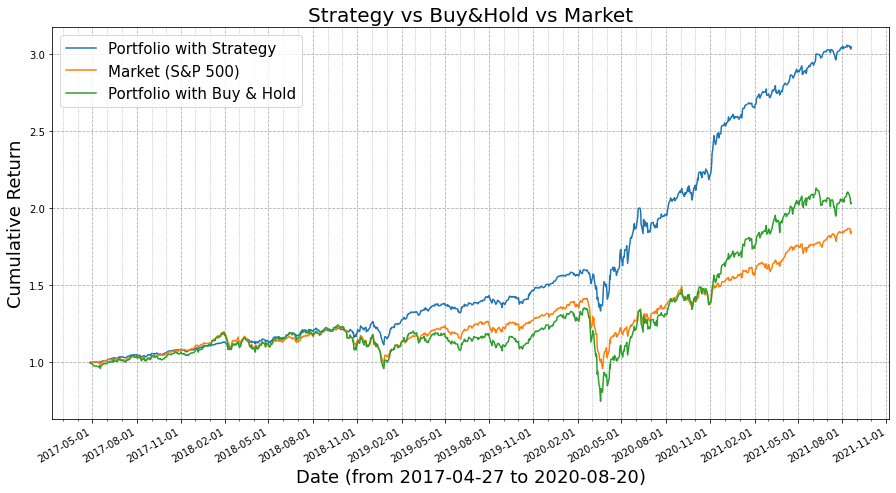

In [435]:
import datetime as dt
import matplotlib
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15, 8))

years_months_days_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(years_months_days_fmt)

ax.plot(df.portfolio, label='Portfolio with Strategy')
ax.plot(spy.buy_and_hold_equity, label='Market (S&P 500)')
ax.plot(df_open_ret.portfolio, label='Portfolio with Buy & Hold')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.legend(fontsize=15)

fig.autofmt_xdate()

ax.set_ylabel('Cumulative Return', size=18)
ax.set_xlabel('Date (from 2017-04-27 to 2020-08-20)', size=18)
ax.set_title('Strategy vs Buy&Hold vs Market', size=20)

ax.grid(which='major', linestyle='--')
ax.grid(which='minor', linestyle=':')

In [226]:
spy = stock('^GSPC')

In [227]:
spy = spy[spy.index > '2017-04-26']

In [228]:
spy['ret'] = spy.Open / spy.Open.shift(1) - 1

In [229]:
spy['buy_and_hold_equity'] = (spy.ret + 1).cumprod()

In [233]:
spy.tail()

,Adj Close,Open,Volume,hi_over_fivedavghi,low_over_fivedavglow,Five Days Avg Close,Five Days Avg Volume,momentum,RSI6,RSI12,RSI24,std,Adj Close 3 avg,check,ret,buy_and_hold_equity
Date,,,,,,,,,,,,,,,,
2021-08-16,4479.709961,4461.649902,2707170000,1.004315,0.999433,4418.806838,2.729112e+09,0.010685,79.685957,69.317968,64.522263,17.838720,4469.513346,0,-0.000714,1.867034
2021-08-17,4448.080078,4462.120117,2884000000,0.999491,0.995514,4421.734162,2.661944e+09,0.002554,53.775486,59.169810,60.238843,15.037209,4465.263346,1,0.000105,1.867230
2021-08-18,4400.270020,4440.939941,2965210000,0.997526,0.992690,4419.587747,2.694374e+09,-0.009486,33.825555,47.663467,54.529125,30.786501,4442.686686,1,-0.004747,1.858367
2021-08-19,4405.799805,4382.439941,3120840000,0.991445,0.988996,4418.208953,2.809770e+09,-0.012336,37.066056,48.916874,55.043410,35.963876,4418.049967,1,-0.013173,1.833887
2021-08-20,4441.669922,4410.560059,2867770000,0.998297,1.000290,4420.555050,2.908998e+09,-0.005893,54.434585,56.319530,58.240355,32.685332,4415.913249,1,0.006417,1.845654


In [299]:
stock_list_final20

['OKE',
 'MCHP',
 'CCL',
 'PENN',
 'IPG',
 'ADSK',
 'ANTM',
 'CRL',
 'FCX',
 'HSIC',
 'BIIB',
 'FFIV',
 'UPS',
 'CAG',
 'CRM',
 'MOS',
 'ITW',
 'VRTX',
 'EFX',
 'TSN']

In [332]:
###########################eliminate survival bias###################
###########################randomly pick 20 stocks##################

In [334]:
import random

In [445]:
results_random = results_408[(results_408['Trade count'] > 10) & (results_408['Profit factor'] > 1)
                             & (results_408['Accuracy']> 0.5)]

In [398]:
results_random

,Stock Name,Accuracy,IRR_strategy,IRR_buyhold,Win rate,Profit factor,Trade count
4,ATVI,0.531680,0.116337,0.117068,0.608696,2.515887,23
7,AAP,0.531187,0.226190,0.223836,0.666667,4.278547,27
9,AFL,0.501377,0.096332,0.097031,0.750000,1.643899,32
13,ALK,0.524334,0.007153,-0.112934,0.535714,1.509365,28
14,ALB,0.552801,0.121809,0.170949,0.650000,1.439754,20
22,AMZN,0.563820,0.322686,0.338014,0.857143,12.216955,14
27,AMT,0.560147,0.185846,0.217928,0.500000,1.747620,26
33,ANSS,0.528007,0.271221,0.314735,0.571429,2.471033,42
34,ANTM,0.555110,0.219647,0.178673,0.681818,4.063002,22
35,AON,0.528007,0.189415,0.212952,0.909091,13.708515,22


In [446]:
results_random_stock_list = results_random['Stock Name'].tolist()

In [447]:
random_pick = random.choices(results_random_stock_list, k = 20)

In [448]:
random_pick

['TPR',
 'IFF',
 'BBWI',
 'TT',
 'SRE',
 'CNP',
 'BMY',
 'RSG',
 'LUV',
 'UPS',
 'JNPR',
 'D',
 'OKE',
 'HST',
 'OKE',
 'TT',
 'SNPS',
 'BA',
 'ALK',
 'CRM']

In [449]:
%%time
stock_list = random_pick
ticker_list = []
score_list = []
IRR_strategy_list = []
IRR_buyhold_list = []
win_rate_list = []
profit_factor_list = []
trade_count_list = []
column_list = []
open_ret_list = []

for i in stock_list:
    
    df = stock(i)
    
    ticker_list.append(df)
    
    X = df[['Adj Close','Volume','hi_over_fivedavghi','low_over_fivedavglow',
                'Five Days Avg Close','Five Days Avg Volume','momentum','RSI6','RSI12','RSI24','std']]
    Y = df['check']
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42, shuffle = False)
    
#    xgbc = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
 
    xgbc = XGBClassifier(silent=False, 
                     scale_pos_weight=1,
                     learning_rate=0.01,  
                     colsample_bytree = 1,
                     subsample = 0.8,
                     objective='binary:logistic', 
                     n_estimators=1500, 
                     reg_alpha = 0.3,
                     max_depth=5, 
                     gamma=1,
                     use_label_encoder=False, 
                     eval_metric='auc'
                     )
    
    xgbc.fit(X_train, Y_train)
    
    score = xgbc.score(X_test, Y_test)
    
    score_list.append(score) 
    
    prediction = xgbc.predict(X_test)
    
    IRR_strategy, IRR_buyhold, win_rate, profit_factor, trade_count, column, open_ret = backtest(df)
    
    
    
    IRR_strategy_list.append(IRR_strategy)
    
    IRR_buyhold_list.append(IRR_buyhold)
    
    win_rate_list.append(win_rate)
    
    profit_factor_list.append(profit_factor)
    
    trade_count_list.append(trade_count)
    
    column_list.append(column)
    
    open_ret_list.append(open_ret)

[16:43:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[16:43:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:43:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:43:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

In [450]:
results_random20 = pd.DataFrame(list(zip(stock_list, score_list, IRR_strategy_list,
                                 IRR_buyhold_list, win_rate_list, profit_factor_list, trade_count_list)), 
                       columns =['Stock Name', 'Accuracy', 'IRR_strategy','IRR_buyhold','Win rate','Profit factor', 'Trade count'])

# results_random20.sort_values(by='IRR_strategy', ascending=False).head(30)

In [451]:
results_random20

,Stock Name,Accuracy,IRR_strategy,IRR_buyhold,Win rate,Profit factor,Trade count
0,TPR,0.505233,0.035925,-0.033703,0.500000,1.438212,38
1,IFF,0.513315,0.090349,0.016154,0.866667,6.786540,15
2,BBWI,0.502296,-0.002935,0.106145,0.529412,1.314282,34
3,TT,0.588613,0.295126,0.277516,0.850000,53.736916,20
4,SRE,0.545455,0.044208,0.035730,0.600000,1.175565,35
5,CNP,0.545455,0.030078,-0.021120,0.600000,1.273502,25
6,BMY,0.511478,0.044119,0.057105,0.625000,1.658210,24
7,RSG,0.584940,0.144543,0.159428,0.823529,31.488993,17
8,LUV,0.570248,0.070563,-0.043063,0.583333,1.720546,24
9,UPS,0.505969,0.183805,0.144925,0.882353,62.122432,17


In [452]:
df2 = pd.DataFrame(column_list)
df2 = df2.transpose()

In [453]:
df2.drop(index=df2.index[0], axis=0, inplace=True)
df2.drop(df2.tail(1).index, inplace=True)

In [454]:
df2['sum_ret'] = df2.sum(axis = 1)

In [455]:
df2['ret'] = 0.05 * df2['sum_ret']

In [456]:
df2['portfolio'] = (df2.ret + 1).cumprod()

In [458]:
df2_open_ret = pd.DataFrame(open_ret_list)
df2_open_ret = df2_open_ret.transpose()

In [459]:
df2_open_ret.drop(index=df2_open_ret.index[0], axis=0, inplace=True)
df2_open_ret.drop(df2_open_ret.tail(1).index, inplace=True)
df2_open_ret = df2_open_ret.fillna(0)

In [460]:
df2_open_ret['sum_ret'] = df2_open_ret.sum(axis = 1)

In [461]:
df2_open_ret['ret'] = 0.05 * df2_open_ret['sum_ret']

In [462]:
df2_open_ret['portfolio'] = (df2_open_ret.ret + 1).cumprod()

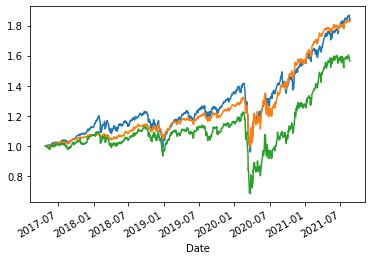

In [463]:
spy.buy_and_hold_equity.plot()
df2.portfolio.plot()
df2_open_ret.portfolio.plot()

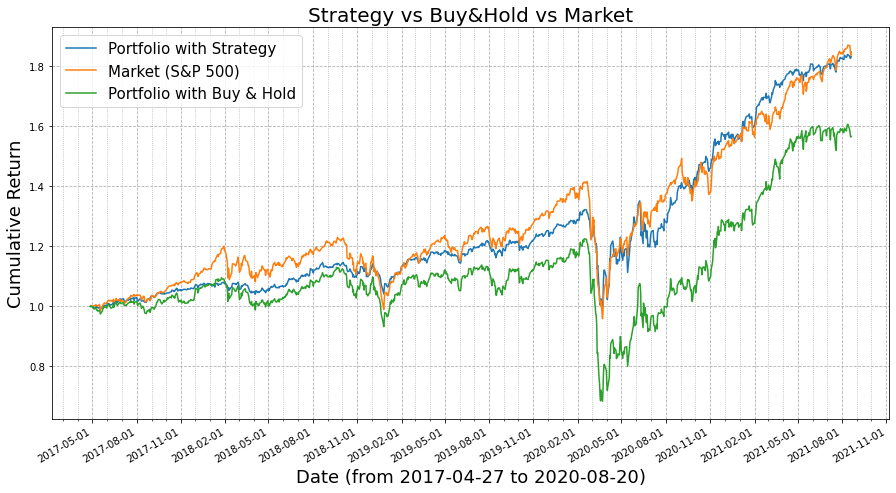

In [464]:
fig, ax = plt.subplots(figsize=(15, 8))

years_months_days_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(years_months_days_fmt)

ax.plot(df2.portfolio, label='Portfolio with Strategy')
ax.plot(spy.buy_and_hold_equity, label='Market (S&P 500)')
ax.plot(df2_open_ret.portfolio, label='Portfolio with Buy & Hold')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.legend(fontsize=15)

fig.autofmt_xdate()

ax.set_ylabel('Cumulative Return', size=18)
ax.set_xlabel('Date (from 2017-04-27 to 2020-08-20)', size=18)
ax.set_title('Strategy vs Buy&Hold vs Market', size=20)

ax.grid(which='major', linestyle='--')
ax.grid(which='minor', linestyle=':')

In [465]:
######################IRR for portfilio using strategy
df2.portfolio[-1] ** (252/len(df2)) - 1

0.1503413402621927

In [466]:
######################IRR for portfilio using Buy Hold
df2_open_ret.portfolio[-1] ** (252/len(df2)) - 1

0.10919168394858536

In [467]:
######################ROI for portfolio using Buy Hold
df2_open_ret.portfolio[-1] -1

0.5642790553079102

In [468]:
######################ROI for portfolio using strategy
df2.portfolio[-1] -1

0.8306991594634379